In [1]:
import numpy as np
import pandas as pd
import pickle
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve

In [2]:
def splitData():
    df_train_neg = df_train.loc[df_train['isFraud'] == 0]
    df_train_pos = df_train.loc[df_train['isFraud'] == 1]
    
    split = 0.2
    x_train_pos, x_val_pos = train_test_split(df_train_pos, test_size=split, random_state=42)
    x_train_neg, x_val_neg = train_test_split(df_train_neg, test_size=split, random_state=42)
    
    #downsample the majority to achieve 1:1 class distribution
    x_train_neg = x_train_neg.sample(frac=1/27)
    x_val_neg   = x_val_neg.sample(frac=1/27)
    
    #combine and reshuffle training and validation sets
    x_train = (x_train_pos.append(x_train_neg)).sample(frac=1)
    x_val   = (x_val_pos.append(x_val_neg)).sample(frac=1)
    
    y_train = x_train.pop('isFraud')
    y_val   = x_val.pop('isFraud')
    
    return x_train, x_val, y_train, y_val

Time READ: 0.35967350006103516 seconds
PREPRO: 0.578000545501709 seconds
FIT: 1.912947654724121 seconds
SCORE: 15.646742343902588 seconds
NEAREST_NEIGHBORS
Nearest_Neighbors scored: 0.7488628202058893
PREDICTION: 15.750691175460815 seconds
[[3108 1113]
 [ 985 3148]]
              precision    recall  f1-score   support

           0       0.76      0.74      0.75      4221
           1       0.74      0.76      0.75      4133

   micro avg       0.75      0.75      0.75      8354
   macro avg       0.75      0.75      0.75      8354
weighted avg       0.75      0.75      0.75      8354

PROBABILITY PREDICTION: 15.081343650817871 seconds


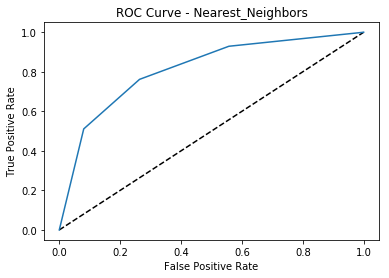

AUC: 0.8124459277013708
TOTAL for Nearest_Neighbors : 1034.8502111434937 seconds


In [ ]:
names = ["Nearest_Neighbors", "Linear_SVM", "RBF_SVM", "Gaussian_Process",
         "Decision_Tree", "Random_Forest", "Neural_Net", "AdaBoost",
         "Naive_Bayes", "QDA", "Logistic_Regression"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()]

#X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
#                           random_state=1, n_clusters_per_class=1)
#rng = np.random.RandomState(2)
#X += 2 * rng.uniform(size=X.shape)
#linearly_separable = (X, y)
start = time.time()
# array of tuples: train and test in each tuple.
with open('df_test_cleaned.pickle','rb') as f:
    df_test = pickle.load(f)
with open('df_train_cleaned.pickle','rb') as g:
    df_train = pickle.load(g)
with open('df_test_transactionids.pickle','rb') as h:
    df_test_transactionids = pickle.load(h)

read = time.time()
print('Time READ: ' + str(read - start) + ' seconds')
datasets = [(df_train,df_test)]

# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
#    X, y = ds
#    X = StandardScaler().fit_transform(X)
#    X_train, X_test, y_train, y_test = \
#        train_test_split(X, y, test_size=.4, random_state=42)

    start2 = time.time()
    X_train, X_test, y_train, y_test = splitData()
    prepro = time.time()
    print('PREPRO: ' + str(prepro - start2) + ' seconds')
    
    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        startloop = time.time()
        print("Starting :" + name)
        clf.fit(X_train, y_train)
        fittime = time.time()
        print('FIT: ' + str(fittime - startloop) + ' seconds')
        score = clf.score(X_test, y_test)
        scoretime = time.time()
        print('SCORE: ' + str(scoretime - fittime) + ' seconds')
        print(name.upper())
        print("===========================")
        print(name + " scored: " + str(score))

        # P R E D I C T
        # Predict the labels of the test set: y_pred
        y_pred = clf.predict(X_test)
        predtime = time.time()
        print('PREDICTION: ' + str(predtime - scoretime) + ' seconds')
        #
        # E V A L U A T E
        #
        # Compute and print the confusion matrix and classification report
        print(confusion_matrix(y_test, y_pred))
        print(classification_report(y_test, y_pred))

        # R O C 
        # Compute predicted probabilities: y_pred_prob
        y_pred_prob = clf.predict_proba(X_test)[:,1]
        prdprobtime = time.time()
        print('PROBABILITY PREDICTION: ' + str(prdprobtime - predtime) + ' seconds')

        # Generate ROC curve values: fpr, tpr, thresholds
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

        # Plot ROC curve
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr, tpr)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve - ' + name)
        plt.show()        
        
        # AUC Calculations
        # A U C
        # Compute predicted probabilities: y_pred_prob
        #y_pred_prob = clf.predict_proba(X_test)[:,1]

        # Compute and print AUC score
        print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

        # Compute cross-validated AUC scores: cv_auc
        #X = df_train.drop('isFraud',axis=1)
        #y = df_train['isFraud']
        #cv_auc = cross_val_score(clf,X,y,scoring='roc_auc',cv=5)
        # Print list of AUC scores
        #print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))
        
        y_real_pred = clf.predict_proba(df_test)[:,1]
        results_dict = dict(zip(df_test_transactionids.to_list(),y_real_pred))
        items = results_dict.items()
        results_df = pd.DataFrame({'TransactionID': [i[0] for i in items], 'isFraud': [i[1] for i in items]})
        csv_name = 'results_'+name+'.csv'
        results_df.to_csv(csv_name,index=False)
        fintim = time.time()
        print('TOTAL for ' + name + ' : ' + str(fintim - startloop) + ' seconds')
        print("===========================")
        print("===========================")